[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Albly/Sparce_image_reconstruction/blob/master/notebooks/tests.ipynb)

In [1]:
from IPython import get_ipython
import os 
import sys
from pathlib import Path

%load_ext autoreload
%autoreload 2

# check if we use colab or local machine
if 'google.colab' in str(get_ipython()):
    IS_COLAB = True
    print('Running on colab')
else:
    IS_COLAB = False
    print('Running on local machine')

if IS_COLAB:
    git_root = !git rev-parse --show-toplevel
    already_in_repo = os.path.exists(git_root[0])

    if not already_in_repo:
        !git clone https://github.com/Albly/Sparce_image_reconstruction $repo_dir

    sys.path.append('Sparce_image_reconstruction')

else:
    os.chdir(Path().absolute().parent)

Running on local machine


In [2]:
import torch
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm, trange
from scipy import sparse
import numpy as np

from metrics import *
from utils import *
from recoverers import activations as act
from recoverers.classical import *

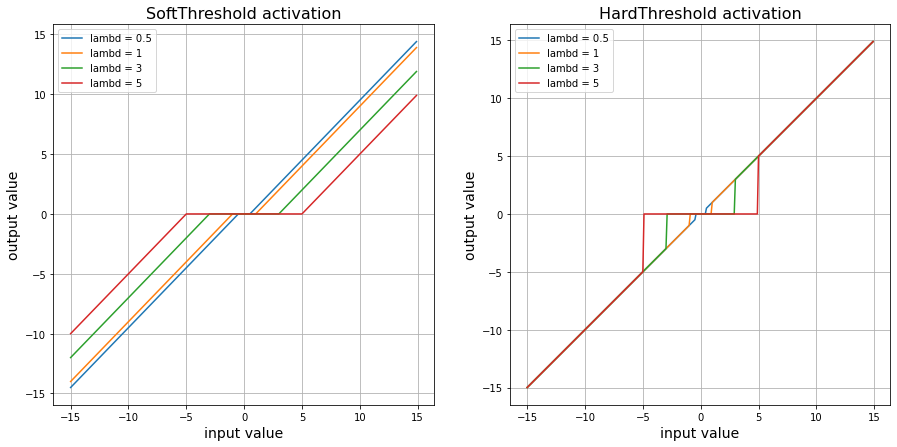

In [3]:
### Test of SoftThresholding and HardThresholding activation
x = torch.arange(-15,15, 0.1)
lambdas = [0.5, 1, 3, 5]

plt.figure(figsize=(15,7))
plt.subplot(1,2,1)

# SoftThresholding
for lambd in lambdas:
    out = act.threshold(x,lambd,'soft')
    plt.plot(x,out, label = 'lambd = '+ str(lambd))

plt.grid()
plt.xlabel('input value', fontsize = 14)
plt.ylabel('output value', fontsize = 14)
plt.title('SoftThreshold activation', fontsize = 16)
plt.legend()

plt.subplot(1,2,2)
# SoftThresholding
for lambd in lambdas:
    out = act.threshold(x,lambd,'hard')
    plt.plot(x,out, label = 'lambd = '+ str(lambd))

plt.grid()
plt.legend()
plt.xlabel('input value', fontsize = 14)
plt.ylabel('output value', fontsize = 14)
plt.title('HardThreshold activation', fontsize = 16)

plt.show()



Iterative methods:

In [87]:

M = 250 # output vector size
N = 500 # input vector size

x = sparse.rand(m = N, n = 1, density = 0.1) # generate random sparce vector
A = np.random.normal(size=(M,N), scale = 1.0/np.sqrt(M)).astype(np.float32) # random matrix 
A = A/np.linalg.norm(A,2)

x = torch.tensor(x.A, dtype = torch.float32)
A = torch.tensor(A, dtype = torch.float32)

n = get_noise(A@x , 40)

y = A@x + n


In [88]:
x_hat, nmses = ista_denoise(y,A,x,0.001, 2000)
x_hat2, nmses2 = fista_denoise(y,A,x, 0.001,2000)
x_hat3, nmses3 = amp_denoise(y,A,x, 0.4,500)

Text(0, 0.5, 'SNR [dB]')

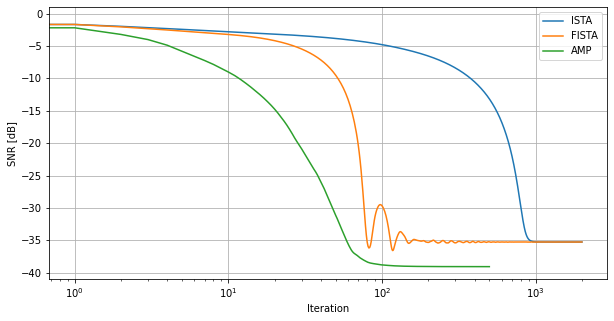

In [89]:
plt.figure(figsize = (10,5))
plt.plot(toDb(nmses), label ='ISTA')
plt.plot(toDb(nmses2), label ='FISTA')
plt.plot(toDb(nmses3), label ='AMP')
#plt.plot(toDb(torch.tensor(metrics)), label ='LISTA')

plt.xscale('log')
plt.grid()
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('SNR [dB]')

In [91]:
from recoverers.lernable import Lista


lista = Lista(A = A, layers = 16)
optimizer = torch.optim.Adam(lista.parameters(), lr = 1.0e-4)
loss_f = torch.nn.MSELoss()

losses = []
metrics = []
for i in range(1000):
    optimizer.zero_grad()

    x_hat = lista.forward(y)
    
    
    loss_value = loss_f(x_hat, x)
    metric = NMSE(x_hat, x)

    losses.append(loss_value.item())
    metrics.append(metric.item())

    loss_value.backward()
    optimizer.step()

Text(0, 0.5, 'SNR [dB]')

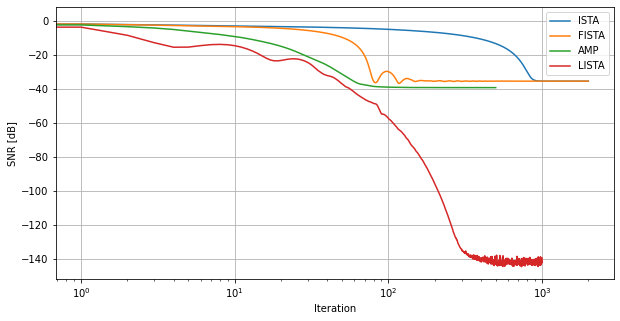

In [92]:
plt.figure(figsize = (10,5))
plt.plot(toDb(nmses), label ='ISTA')
plt.plot(toDb(nmses2), label ='FISTA')
plt.plot(toDb(nmses3), label ='AMP')
plt.plot(toDb(torch.tensor(metrics)), label ='LISTA')

plt.xscale('log')
plt.grid()
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('SNR [dB]')